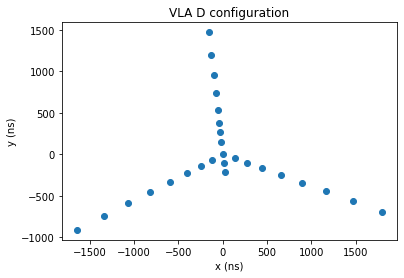

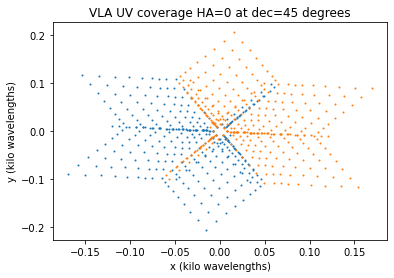

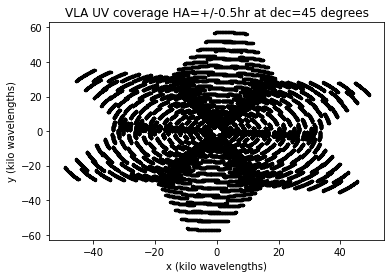

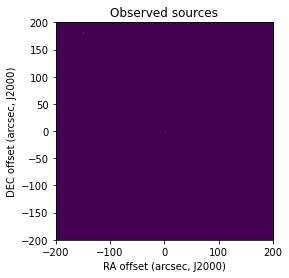

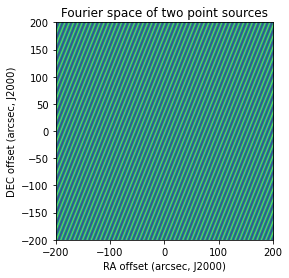

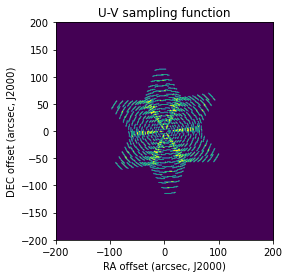

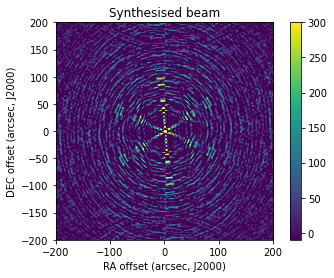

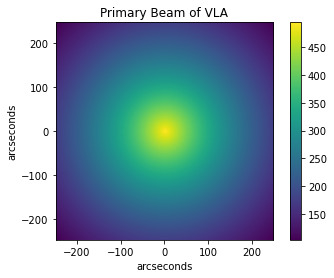

In [109]:
# Thomas Dugdale - Radio Astronomy Assignment - Simulating a Radio Interferometer
# Student ID - 10784808

# Link to binder: https://mybinder.org/v2/gh/ThomasNose/Interferometer-Basic-Simulator.git/HEAD


# References

# http://www-static-2019.jmmc.fr/mirrors/obsvlti/book/Segransan_1.pdf - Used for uv-plane equations
# https://matplotlib.org/3.1.1/api/ - Where I collected different commands for matplotlib
# https://online.manchester.ac.uk/webapps/blackboard/execute/content/file?cmd=view&content_id=_12102131_1&course_id=_63179_1

import numpy as np                                                     # Importing packages
import matplotlib.pyplot as plt
%matplotlib inline


def data(config,source): # Data function
    config = np.loadtxt(config)                                       # Loading in VLA configuration D data
    source = np.loadtxt(source)                                       # Source 1 and 2 data
    
    return (config,source)
config,source = data("Dconfig.txt","source.txt")

def configuration(config,source):                                     # Telescope configuration
    XYZ = config[:,0:3]                                               # Array with VLA data

    RAh,RAm,RAs = source[:,0],source[:,1],source[:,2]                 # Collecting the hours, minutes, seconds of Right Ascension
    DECh,DECm,DECs = source[:,3],source[:,4],source[:,5]              # Collecting source declinations
    JySource = source[:,6]

    Y,Z = config[:,1],config[:,2]                                     # Telescope coordinates
    plt.scatter(Y,Z)                                                  # Plotting the positions of the antennas
    plt.title('VLA D configuration')
    plt.ylabel('y (ns)')
    plt.xlabel('x (ns)')
    plt.show()
    
    return(Y,Z)
Y,Z = configuration(config,source)


def uvcoverage(config,declination): # U-V coverage at HA = 0 function
    DATA = []                                                         # Empty arrays for modulus baselines, Azimuth and Elevation values
    for i, x_i in enumerate(config):                                  # This loop is for calculating all 351 baselines, elevations and azimuth components
        for j, y_i in enumerate(config):
            if i < j:                                                 # This condition ensures no duplicate values are calculated, ie 2-1 and 1-2, 10-5 and 5-10 etc.
                DATA.append(x_i-y_i)
            
    DATA = np.array(DATA)                                             # Loading in all the antenna coordinates
    X = DATA[:,0]                                                     # Allocating to X,Y,Z
    Y = DATA[:,1]
    Z = DATA[:,2]

    dec = declination

    U = Lambda*(np.sin(0)*X + np.cos(0)*Y)                            # U-V values, again with RA set to 0 hrs
    V = Lambda*(-np.sin(dec)*np.cos(0)*X + np.sin(dec)*np.sin(0)*Y + np.cos(dec)*Z) # Equations taken from Neal Jackson and Segransan

    plt.scatter(V/1e3,U/1e3,s=1)                                      # Plotting the UV coverage which is both the positive and negatives values of U and V
    plt.scatter(-V/1e3,-U/1e3,s=1)                                    # Values for U and V are divided by 1,000 to match the units used in the VLA document provided
    plt.xlabel('x (kilo wavelengths)')
    plt.ylabel('y (kilo wavelengths)')
    plt.title('VLA UV coverage HA=0 at dec=45 degrees')
    plt.show()
    
    return(X,Y,Z,dec)
X,Y,Z,dec = uvcoverage(config,np.pi/4)                                # 45 degree declination

def uvcoverageHA(hour,Interval,X,Y,Z,dec): # U-V coverage function for HA 
    
    T = (2*np.pi/24) * hour                                           # Equation which converts the input time (in hours) to radians
    interval = (hour * 3600) // Interval                              # The interval is every 30 seconds to this says how many data points there should be
    
    t = np.linspace(-T/2,T/2,interval)                                # One hour of RA in radians from -0.5 hr to +0.5hr
    u = []                                                            # Blank u-v arrays for appending
    v = []

    for i in range(len(X)):                                           # Loop for calculating u-v
        u = np.append(u, (f/c)*(np.sin(t)*X[i] + np.cos(t)*Y[i]))     # Equations taken from Segransan + Neal Jackson lectures
        v = np.append(v, (f/c)*(-np.sin(dec)*np.cos(t)*X[i] + np.sin(dec)*np.sin(t)*Y[i] + np.cos(dec)*Z[i]))

    plt.scatter(v/1e3,u/1e3,s=5,c='black')                            # Plotting the u-v plane
    plt.scatter(-v/1e3,-u/1e3,s=5,c='black')                          # Negative have to be plotted for other half of u-v plane
    plt.xlabel('x (kilo wavelengths)')
    plt.ylabel('y (kilo wavelengths)')
    plt.title('VLA UV coverage HA=+/-0.5hr at dec=45 degrees')
    plt.show()
    
    return(u,v)
u,v = uvcoverageHA(1,30,X,Y,Z,dec)                                    # 1 hour (+/- 0.5HA) at 30 second intervals


def truesky(extent_x,extent_y): # Function to be recalled
    TrueSky = np.zeros((extent_x,extent_y))                           # Blank array for point sources
    
    centre_x,centre_y = int(extent_x/2),int(extent_y/2)               # Centre value of image
    
    TrueSky[centre_x,centre_y] = JySource[0]                          # This is the first centred image
    TrueSky[20,50] = JySource[1]                                      # This is the second source. 3 arc minutes difference in Declination and 10 seconds difference in RA.

    plt.imshow(TrueSky,extent=[-centre_x,centre_x,-centre_y,centre_y])# This is an image of the two sources
    plt.title('Observed sources')
    plt.xlabel('RA offset (arcsec, J2000)')
    plt.ylabel('DEC offset (arcsec, J2000)')

    plt.show()
    return(TrueSky)
TrueSky = truesky(400,400)

def visibility(truesky):                                              # Function for fourier transforming to get visibilies

    Visibility = np.fft.fft2(TrueSky)                                 # Fourier transform of sources
    plt.imshow(np.real(Visibility),extent=[-200,200,-200,200])        # This image shows the real fourier space of the two observed sources
    plt.xlabel('RA offset (arcsec, J2000)')
    plt.ylabel('DEC offset (arcsec, J2000)')
    plt.title('Fourier space of two point sources')
    plt.show()
    
    return(Visibility)
Visibility = visibility(TrueSky)

def sampling(extent_x,extent_y,scale):                                # Function for sampling function

    Sampling = np.zeros((extent_x,extent_y))                          # Empty array for sampling function 
    for i in range(len(u)):
        Sampling[int(u[i]/scale),int(v[i]/scale)] = 1                 # Fills in empty image array with a 1 if uv data exists
        Sampling[int(-u[i]/scale),int(-v[i]/scale)] = 1               # also divided by 500 so all u,v data fits within sampling array
    ShiftSampling = np.fft.fftshift(Sampling)                         # Shifts the image to the centre of the spectrum
    
    centre_x,centre_y = int(extent_x/2), int(extent_y/2)              # Values for centering the image
    
    plt.imshow(np.real(ShiftSampling),extent=[-centre_x,centre_x,-centre_y,centre_y]) # Plotting sampling function
    plt.title('U-V sampling function')                                # sampled grid
    plt.xlabel('RA offset (arcsec, J2000)')
    plt.ylabel('DEC offset (arcsec, J2000)')
    plt.show()

    return(Sampling)
Sampling = sampling(400,400,500)                                      # size 400x400 with pixels being 500 data points each
    
def synthesise(extent_x,extent_y,sample_function): # Synthesised beam function
    
    centre_x,centre_y = int(extent_x/2), int(extent_y/2)              # Values for centering the image

    Synthesised = np.fft.fft2(sample_function)                        # Fourier transform of UV image to show synthesised(dirty) beam image
    Synthesised = np.fft.fftshift(Synthesised)                        # This command shifts the image to the centre of the plot rather than being at the corners
    Synthesised = np.real(Synthesised)
    plt.imshow(Synthesised,vmin=-10,vmax=300,extent=[-centre_x,centre_x,-centre_y,centre_y]) # Real values plotted
    plt.title('Synthesised beam')                                     # vmin and vmax values best show the dirty beam
    plt.colorbar()                                                    # Shows values of the synthesised beam
    plt.xlabel('RA offset (arcsec, J2000)')
    plt.ylabel('DEC offset (arcsec, J2000)')
    plt.show()
    
    return(Synthesised)
Synthesised = synthesise(400,400,Sampling)                            # Size 400x400 with sampling function as input

def dirtymap(extent_x,extent_y,sample_function,visibility): # Dirty map function

    centre_x,centre_y = int(extent_x/2), int(extent_y/2)              # Values for centering the image
    
    SampleVis = Sampling * Visibility                                 # Multiplying together to get sampled visibilities
    DirtyMap = np.fft.ifft2(SampleVis)                                # Inverse fourier transform to get from sampled visibilities to dirty map
    plt.imshow(np.real(DirtyMap),extent=[-centre_x,centre_x,-centre_y,centre_y]) # Plotting and centering dirty map
    plt.xlabel('RA offset (arcsec, J2000)')
    plt.ylabel('DEC offset (arcsec, J2000)')
    plt.title('Dirty map')
    plt.show()

    return(DirtyMap)
DirtyMap = (400,400,Sampling,Visibility)                              # 400x400 dirty map


def radius(Lambda,D): # Primary beam radius in arcseconds function
    Primary = Lambda / D                                              # Angular size of primary beam in radians at 5GHz with 25m apertures
    PrimaryDeg = Primary * (180/np.pi) * 3600                         # Angular size of beam in arcseconds
    radius = int(np.round(PrimaryDeg/2))                              # Integer and rounded value for radius of primary beam in arcseconds
    
    return(radius)
radius = radius(3e8/5e9,25)                                           # Inputting wavelength calculated by c/f and inputting 25 metre aperture diameter

def primarybeam(extent_x,extent_y,Radius): # Primary beam function

    centre_x,centre_y = int(extent_x/2), int(extent_y/2)              # Values for centering the image
    
    x = np.linspace(1,2*radius,2*Radius)                              # Creating lists for meshgrid that range over the width of the beam
    y = np.linspace(1,2*radius,2*Radius)
    xx, yy = np.meshgrid(x,y)                                         # Meshgrid for calculating distance to a pixel

    PrimaryBeam = np.zeros((2*Radius,2*Radius))                       # Blank image for primary beam of size width of primary beam
    for i in range(1,2*Radius):                                       # Loop creating the primary beam
        r = ((xx-x[Radius])**2 + (yy-y[Radius])**2)**0.5              # Length from the centre of the primary beam                  
        PrimaryBeam += np.exp(-(r/[i])**2)                            # 'Temporary' equation for the primary beam
                          
    plt.imshow(PrimaryBeam,extent=[-centre_x,centre_x,-centre_y,centre_y]) # Primary beam plotted, centre image is [0,0]
    plt.xlabel('arcseconds') 
    plt.ylabel('arcseconds')
    plt.title('Primary Beam of VLA')
    plt.colorbar()
    plt.show()
    
    return(PrimaryBeam)
PrimaryBeam = primarybeam(2*radius,2*radius,radius)                   # Primary beam with diameter 2*radius